# Python notebook for finding peaks in csv file data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
NOTE: Looks for data files in the image_stacks directory.<br>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
from __future__ import print_function
import csv
import datetime
import glob
import os
from ipywidgets import interact, Layout
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import signal

# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"


#### Create a new time-stamped results directory.

In [2]:
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)


#### Select a data file and one or more regions.
NOTE: Assumes file format in which the first column contains time values in seconds and subsequent region columns contain intensity data.<br>
Select multiple regions using &lt;command-click&gt;.

In [3]:
%matplotlib widget

# global variables
data_file = ""  # the selected data file
data_cols = []  # the data columns

# create data files widget
data_files = sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*.csv", recursive=False)], key=str.casefold)
data_files_widget = widgets.Select(options=data_files, description='Data file', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'100px'})
# create region columns widget
columns_widget = widgets.SelectMultiple(options=[], description='Region cols',
                            disabled=False, layout={'width':'150px', 'height':'120px'}, style={'description_width':'100px'})

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# update the columns based on the data file selection
def update_columns(*args):
  if data_files_widget.value == None:
    return
  with open("../image_stacks/" + data_files_widget.value, 'r', encoding='utf-8-sig') as f: 
    cols = (np.genfromtxt(f, dtype=float, delimiter=',')).shape[1]
  columns_widget.options = range(1,cols)
  columns_widget.value = [1]

# widget change callbacks
data_files_widget.observe(update_columns, 'value')

# display and respond to the widgets
update_columns()
def f(w1, w2, w3):
  global data_file, data_cols, zones
  data_file = data_files_widget.value
  data_cols = columns_widget.value
  if not data_file:
    status_widget.value = "No data file selected."
  else:
    if not data_cols:
      status_widget.value = "No region(s) selected."
    else:
      status_widget.value = "Selection OK."

display(widgets.interactive(f, w1=data_files_widget, w2=columns_widget, w3=status_widget))


interactive(children=(Select(description='Data file', layout=Layout(width='400px'), options=('gCAMP Template-E…

#### Plot data.

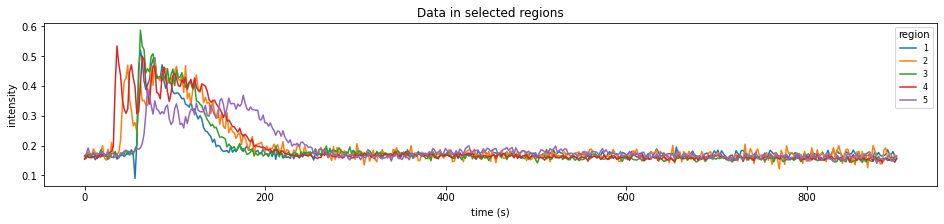

In [4]:
%matplotlib inline

#global variables
cols = np.array(data_cols)

with open("../image_stacks/" + data_file, 'r', encoding='utf-8-sig') as f: 
  A0 = np.transpose(np.genfromtxt(f, dtype=float, delimiter=','))
tmin = np.min(A0[0])            # start time
tmax = np.max(A0[0])            # finish time

dmin = np.amin(A0[cols])
dmax = np.amax(A0[cols])

plt.close('all')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
ax.set_title("Data in selected regions")
ax.set(ylabel="intensity")
ax.set(xlabel="time (s)")
ax.plot(A0[0],np.transpose(A0[cols]))
if len(data_cols) < 11:
  ax.legend(cols, title='region', fontsize=8)
plt.show()


#### Set stimulation time zone ranges.

In [5]:
%matplotlib widget

# global variables
zones = [] # stimulation time zones 

# create number of zones widget
num_zones_widget = widgets.Dropdown(
    options=['1','2','3','4','5','6'],
    value='1',
    description='Number of zones:',
    disabled=False,
    layout={'width':'270px'}, style={'description_width':'200px'}
)

# create zone widget(s)
zone_widgets = []
for i in range(len(num_zones_widget.options)):
    zone_widgets.append(widgets.IntRangeSlider(
        value=(tmin,tmin), min=tmin, max=tmax, step=10,
        description="Stimulation zone " + str(i+1) +' (s)',
        disabled=True, continuous_update=False, orientation='horizontal',
        readout=True, readout_format='d',
        layout={'width':'700px'}, style={'description_width':'200px'}))

# update the zone widgets based on the number of zones value
def update_zone_widgets(*args):
    for i,z in enumerate(zone_widgets):
        nz = int(num_zones_widget.value) # the desired number of zones
        dt = int(tmax-tmin) / nz
        if(i+1 <= nz):
            z.value = (tmin + (i*dt), tmin + (i+1)*dt)
            z.disabled = False
        else:
            z.value = (tmin,tmin)
            z.disabled = True

# widget change callbacks
num_zones_widget.observe(update_zone_widgets, 'value')

# display and respond to the widgets
update_zone_widgets()
def f(w1, w2, w3, w4, w5, w6, w7):
  global zones
  zones = [w.value for w in zone_widgets if not w.disabled]

display(widgets.interactive(f,
                           w1=num_zones_widget,
                           w2=zone_widgets[0],
                           w3=zone_widgets[1],
                           w4=zone_widgets[2],
                           w5=zone_widgets[3],
                           w6=zone_widgets[4],
                           w7=zone_widgets[5]))


interactive(children=(Dropdown(description='Number of zones:', layout=Layout(width='270px'), options=('1', '2'…

#### Plot data and stimulation time zones.

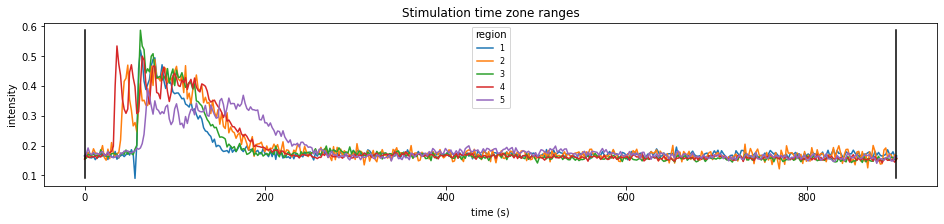

In [6]:
%matplotlib inline

#global variables
zn = np.array(zones)

plt.close('all')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
ax.set_title("Stimulation time zone ranges")
ax.set(ylabel="intensity")
ax.set(xlabel="time (s)")
ax.plot(A0[0],np.transpose(A0[cols]))
ax.plot([zn[:,0],zn[:,0]],[dmin,dmax],color='black')
ax.plot([zn[:,1],zn[:,1]],[dmin,dmax],color='black')
if len(data_cols) < 11:
  ax.legend(cols, title='region', fontsize=8)
plt.show()


#### Set peak counting sensitivity.

In [7]:
%matplotlib widget

# global variables
pk_options = (0,0)

# create number of zones widget
sensitivity_widget = widgets.Dropdown(
    options=[('low',(0.06,4)),('low-medium',(0.05,6)),('medium',(0.04,7)),('high-medium',(0.03,8)),('high',(0.02,9))],
    value=(0.04,7),
    description='Peak counting sensitivity:',
    disabled=False,
    layout={'width':'350px'}, style={'description_width':'180px'}
)

# display and respond to the widgets
def f(w1):
    global pk_options
    pk_options = sensitivity_widget.value
    
display(widgets.interactive(f, w1=sensitivity_widget))


interactive(children=(Dropdown(description='Peak counting sensitivity:', index=2, layout=Layout(width='350px')…

#### Plot peaks by region and plot peak count summary.


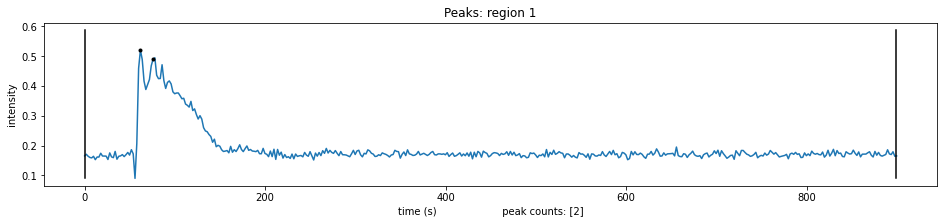

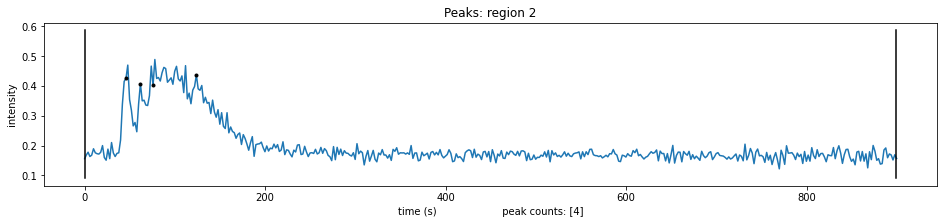

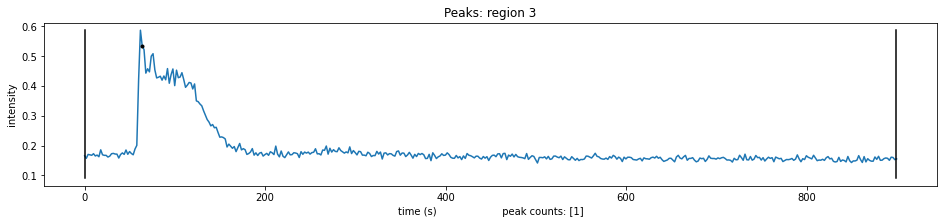

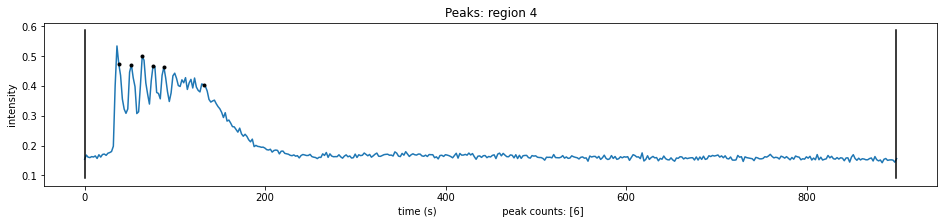

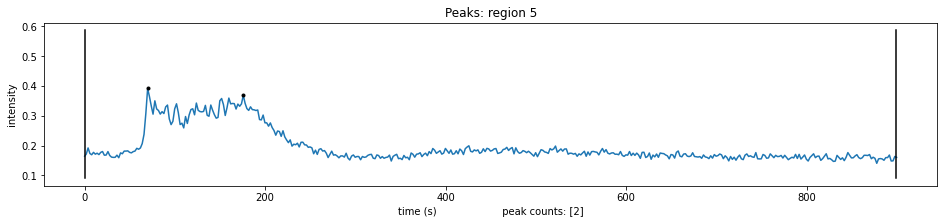

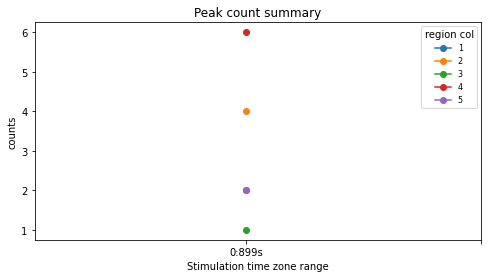

In [8]:
%matplotlib inline

#global variables
zn = np.array(zones)

X0 = A0[0]

sr = 6.0                            # desired sample rate
csr = (len(X0) - 1) / (tmax-tmin)   # current sample rate
p = int((sr / csr) * len(X0))       # new number of points

##### adjustment for different data sources #####
if (csr < 1.0):
  filter_factor = 0.05
  prominence_factor = 3.0
else:
  filter_factor = 1.0
  prominence_factor = 1.0
#################################################

dmin = np.amin(A0[cols])
dmax = np.amax(A0[cols])

for f in glob.glob(resultsdir + "/peaks_*.csv"):
  os.remove(f)  # delete any previous results

plt.close('all')
cts = []
for col in cols:
  Y0 = A0[col]
  Y1 = (Y0-dmin) / (dmax-dmin) # data axis, normalized to range(0, 1.0)

  # resample
  f = interp1d(X0, Y1, kind='cubic')                    # define the resampling function
  X = np.linspace(tmin, tmax, p+1, endpoint=True)       # define the new time steps
  Y = f(X)                                              # resample the original signal

  # apply high-pass filter to eliminate the stimulation "bump" in the data
  sos = signal.butter(3, 0.1*filter_factor, btype='highpass', fs=sr, output='sos')
  Yf = signal.sosfiltfilt(sos, Y) # zero phase shift filter

  # apply low-pass filter to smooth out higher frequencies in the data
  sos = signal.butter(pk_options[1], 2.0*filter_factor, btype='lowpass', fs=sr, output='sos')
  Yf = signal.sosfiltfilt(sos, Yf) # zero phase shift filter

  pks,_ = signal.find_peaks(Yf,prominence=pk_options[0]*prominence_factor)  # find indices of peaks in the resampled, filtered data
  pidx = np.around((X0.shape[0]-1)*pks/p).astype(int) # convert to indices in the original data
  pts = [A0[0][pidx], A0[col][pidx]]                  # save the peaks as points in the original data

  c = []
  for z in zn:
    idx = pidx[(pidx >= np.where(A0[0] > z[0])[0][0]) & (pidx <= np.where(A0[0] < z[1])[0][-1])]
    c.append(len(idx))
  cts.append(c)

  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
  ax.set_title("Peaks: region " + str(col))
  ax.set(xlabel="time (s)                     peak counts: " + str(c))
  ax.set(ylabel="intensity")
  ax.plot(A0[0],A0[col])
  ax.plot(A0[0,pidx],A0[col,pidx],'k.')          # plot the peak locations
  ax.plot([zn[:,0],zn[:,0]],[dmin,dmax],color='black')
  ax.plot([zn[:,1],zn[:,1]],[dmin,dmax],color='black')
  ##ax.plot(X,Yf)
  plt.show()
  plt.close() # frees up memory

  # save peak points to CSV file
  with open (resultsdir + "/peaks_region_" + str(col) + ".csv", 'w') as file:
    writer = csv.writer(file)
    for pk in pidx:
      writer.writerow((A0[0,pk],A0[col,pk]))

# peak count summary
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), constrained_layout=False)
ax.set_title("Peak count summary")
ax.set(xlabel="Stimulation time zone range")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
x_fmt = mpl.ticker.IndexFormatter([str(z[0])+':'+str(z[1])+'s' for z in zones])
ax.xaxis.set_major_formatter(x_fmt)
ax.set(ylabel="counts")
ax.plot(np.transpose(cts), marker='o')
ax.legend(cols, title='region col', fontsize=8)
plt.xlim(-0.9,len(zones))
plt.show()
plt.close()

# save peak count summary to CSV file
with open (resultsdir + "/peaks_summary.csv", 'w') as file:
  writer = csv.writer(file)
  for row in np.transpose(cts):
    writer.writerow(row)
